In [1]:
import backtrader as bt
import yfinance as yf
import pyfolio as pf
import pandas as pd

/opt/anaconda3/lib/python3.11/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
class MACDStrategy(bt.Strategy):

    # U početnoj metodi postavljamo inicijalizacije potrebne za strategiju
    def __init__(self):
        # Inicijalizacija MACD indikatora koristeći cijenu zatvaranja
        self.macd = bt.indicators.MACD(self.data.close)
        
        # Inicijalizacija varijable za praćenje otvorene narudžbe
        self.order = None

    # Ova metoda se izvršava za svaki novi dan/podatak u prosljeđenom datasetu
    def next(self):

        # Radimo provjeru da li imamo otvorenu narudžbu, ako imamo onda preskačemo jedan ciklus (ne želimo stvoriti novu narudžbu dok se trenutna ne izvrši)
        if self.order:
            return

        # Provjera uvjeta za kupnju:
        # 1) Ako nema otvorene pozicije
        # 2) Ako je trenutna vrijednost MACD-a veća od Signal linije
        if not self.position and self.macd.macd[0] > self.macd.signal[0]:
            # Računamo koliko dionica možemo kupiti s trenutnim raspoloživim iznosom
            cash = self.broker.get_cash()
            price = self.data.close[0]
            shares_to_buy = cash // price

            # Ako možemo kupiti barem jednu dionicu, kreiramo narudžbu za kupnju
            if shares_to_buy > 0:
                self.log('Kreiraj kupnju, %.2f' % price)
                self.order = self.buy(size=shares_to_buy)

        # Provjera uvjeta za prodaju:
        # 1) Ako postoji otvorena pozicija
        # 2) Ako je trenutna vrijednost MACD-a manja od Signal linije
        elif self.position and self.macd.macd[0] < self.macd.signal[0]:
            self.log('Kreiraj prodaju, %.2f' % self.data.close[0])
            self.order = self.sell(size=self.position.size)

    # Ova metoda služi za ispis poruka u konzoli
    def log(self, txt):
        dt = self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    # Ova metoda prati status narudžbe i ispisuje logove ovisno o statusu narudžbe
    def notify_order(self, order):
        if order.status == order.Completed:
            if order.isbuy():
                self.log(
                "Izvršena KUPNJA (Cijena: %.2f, Vrijednost: %.2f)" %
                (order.executed.price, order.executed.value))
            else:
                self.log(
                "Izvršena PRODAJA (Cijena: %.2f, Vrijednost: %.2f)" %
                (order.executed.price, order.executed.value))
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Narudžba je otkazana/margina/odbijena")
        self.order = None

In [3]:
def test_strategy(strategy_class, ticker, start_date, end_date, starting_cash=100000):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy_class)
    
    # Preuzimamo podatke i spremamo ih u varijablu
    yf_data = yf.download(ticker, start=start_date, end=end_date)
    data = bt.feeds.PandasData(dataname=yf_data)
    cerebro.adddata(data)
    
    cerebro.broker.setcash(starting_cash)
    cerebro.broker.setcommission(commission=0.0002)
    
    # Dodajemo observer za praćenje vrijednosti portfolija
    cerebro.addobserver(bt.observers.Value)
    
    # Dodajemo analizator za praćenje povrata
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    
    print('Početno stanje portfelja: %.2f' % cerebro.broker.getvalue())
    results = cerebro.run()
    print('Završno stanje portfelja: %.2f' % cerebro.broker.getvalue())
    
    strat = results[0]
    
    # Dohvaćamo podatke iz PyFolio analizatora
    portfolio_value = strat.analyzers.pyfolio.get_pf_items()
    returns, positions, transactions, gross_lev = portfolio_value

    # Dohvaćamo vrijednosti portfolija
    portfolio_values = strat.observers.value.get(size=len(strat))
    
    # Stvaramo DataFrame s datumima i vrijednostima portfolija
    df_portfolio = pd.DataFrame({
        'Date': yf_data.index,
        'Value': portfolio_values
    })    
    
    # Koristimo pyfolio za generiranje izvještaja
    pf.create_simple_tear_sheet(returns)

    return df_portfolio

[*********************100%%**********************]  1 of 1 completed

Početno stanje portfelja: 100000.00
2024-02-26, Kreiraj kupnju, 79.09
2024-02-27, Narudžba je otkazana/margina/odbijena
2024-02-27, Kreiraj kupnju, 78.70
2024-02-28, Izvršena KUPNJA (Cijena: 77.62, Vrijednost: 98577.40)
2024-02-28, Kreiraj prodaju, 77.66
2024-02-29, Izvršena PRODAJA (Cijena: 79.09, Vrijednost: 98577.40)
2024-03-01, Kreiraj kupnju, 82.28
2024-03-04, Narudžba je otkazana/margina/odbijena
2024-03-04, Kreiraj kupnju, 85.24
2024-03-05, Narudžba je otkazana/margina/odbijena
2024-03-05, Kreiraj kupnju, 85.96
2024-03-06, Narudžba je otkazana/margina/odbijena
2024-03-06, Kreiraj kupnju, 88.70
2024-03-07, Narudžba je otkazana/margina/odbijena
2024-03-07, Kreiraj kupnju, 92.67
2024-03-08, Narudžba je otkazana/margina/odbijena
2024-03-08, Kreiraj kupnju, 87.53
2024-03-11, Izvršena KUPNJA (Cijena: 86.43, Vrijednost: 100516.93)
2024-03-14, Kreiraj prodaju, 87.94
2024-03-15, Izvršena PRODAJA (Cijena: 86.93, Vrijednost: 100516.93)
2024-04-30, Kreiraj kupnju, 86.40
2024-05-01, Izvršena


/opt/anaconda3/lib/python3.11/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '67.851%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2024-01-02
End date,2024-07-30
Total months,6
,Backtest
Annual return,67.851%
Cumulative returns,34.716%
Annual volatility,27.076%
Sharpe ratio,2.05
Calmar ratio,5.31
Stability,0.70
Max drawdown,-12.784%


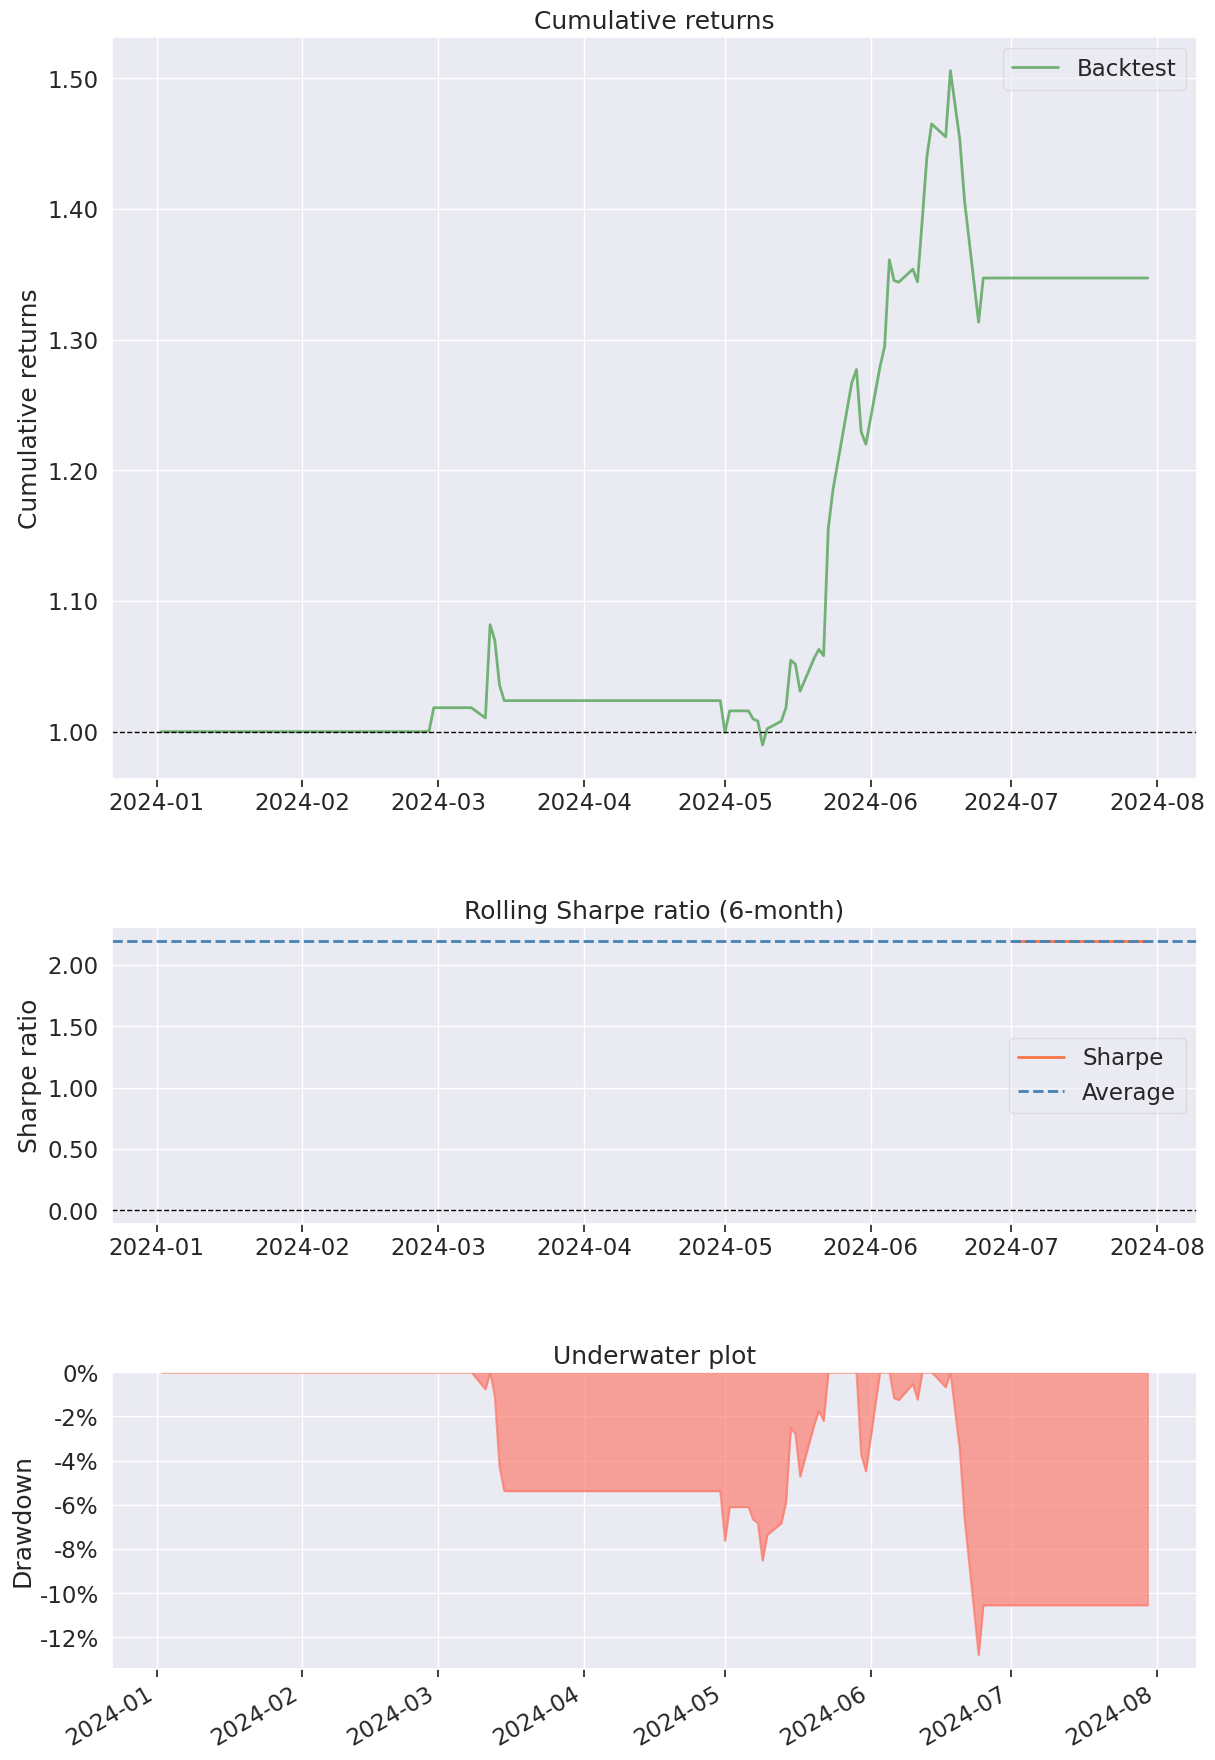

In [4]:
results = test_strategy(MACDStrategy, 'NVDA', '2024-01-01', '2024-07-31')

In [5]:
import pickle

# Za df_account_value_sac
with open('nvda_macd_strategy.pkl', 'wb') as f:
    pickle.dump(results, f)